In [1]:
from IPython.display import HTML
HTML('''
<style>
.prompt {
  display: none;
}
</style>
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import altair as alt
alt.renderers.enable('notebook');

In [3]:

import warnings
warnings.filterwarnings('ignore')


# Hate Crimes: Problem Overview

On November 29, 2018, a psychology professor at Columbia Teachers College walked into her office to be faced with anti-Semitic graffiti: two swastikas and an anti-Semitic slur “Yid”, as featured below. This incident is one example of the rise of anti-semitism and, more broadly, hate crimes within the United States. 
![anti-semitic graffiti](./hate_crime.jpg)

### Project Description
The purpose of the research project is to investigate hate crimes data to better understand relationships between an area’s demographics and socioeconomic levels and incidence of hate crimes. It is an important undertaking because better understanding this data would help us in acknowledging the current trends and common motivations behind hate crimes. Using insights from our analyses, we can then predict hate crime rates based on the appropriate socioeconomic factors.

### About Hate Crimes
- Throughout history, many sociologists have published theories on how social inequality is associated with crimes. Even back in 1947, Edwin Sutherland argued that there are less crimes in “egalitarian, consensual societies” compared to “inequitable societies characterized by conflicting beliefs”. More recently, in their paper, “Divergent Social Worlds: Neighborhood Crime and the Racial-Spatial Divide”, authors Peterson and Krivo found that whites and non-whites “live in divergent socioeconomic worlds generated by racialized social structures, which in turn produce socioeconomic differences and ultimately differences in crime rates”.
[link](http://faculty.washington.edu/matsueda/Papers/Inequality.pdf)
- From 2004 to 2015, the U.S. Department of Justice reported that “U.S. residents experienced an average of 250,000 hate crime victimizations each year”. These include, but are not limited to, assault, sexual assault, rape, robbery, and other types of theft. Also during this same period, 46% of the violent crimes that occured happened in the Western region of the U.S., with urban areas being a high target.
[link](https://www.bjs.gov/content/pub/pdf/hcv0415.pdf)
- Hate crimes are an ongoing problem that don’t seem to be on the decline. In fact, hate crimes in the U.S.’s top ten largest cities increased 12.5% in 2017. Apparently, this “increase was the fourth consecutive annual rise in a row and the highest total in over a decade”. Racial bias is one of the most common motivations crimes from 2011-2015, and in 2017, the most common crimes were committed by those that were anti-Black, anti-Semitic, anti-gay, and anti-Latino.
[link](https://csbs.csusb.edu/sites/csusb_csbs/files/2018%20Hate%20Final%20Report%205-14.pdf)


### The Datasets
For our analysis, we consulted two sources for a total of 8 data tables that detail United States' hate crime incidents and related demographics collected for the year 2016.

[Hate crime data](https://ucr.fbi.gov/hate-crime/2016?fbclid=IwAR1XrwBRWJ40IyGjTS5iVbL6BGAhZEr3mCFthpispOog7p4zMfIGSL0jGy0) from the FBI that includes data about hate crime incidents from 2016, including motivations, victims, offenders, locations, and rates by jurisdiction. The source of their data is Uniform Crime Reporting from local governments. We used 7 tables from this source:

|Table| Title | Data|
|-----|-------|-----|
|Table 1|_Incidents, Offenses, Victims, and Known Offenders by Bias Motivation_|Includes data on the amount of hate incidents/offenses, the number of victims and the number of known offenders for each bias motivation for the whole United States|
|Table 2|_Incidents, Offenses, Victims and Known Offenders by Offense Type_|Similar to the previous table, table 2 Includes data on the amount of hate incidents/offenses, the number of victims and the number of known offenders for each offense type in the entire country.|
|Table 3|_Offenses - Known Offender's Race and Ethnicity by Offense Type_|Includes data on the frequency of each offense type as committed by each race and ethnicity. This table shows us which race is committing the most offenses.|
|Table 4| _Offenses - Offense Type by Bias Motivation_ |Includes data on frequencies of offense type for each bias motivation, for example, that there were 5 murders motivated by anti-white biases.|
|Table 5|_Offenses - Known Offenders Race and Ethnicity by Bias Motivation_|Includes data on the frequency of offenses for each race|
|Table 11|_Offenses - Offense Type by Participating State_|Includes each state except Hawaii who does not participate in reporting, their total offenses and the frequency of each offense type|
|Table 10|_Incidents - Bias Motivation by Location_|Includes data on where the incident occured, such as college/university or highway/road as well as the bias motivation such as sexural orientation. We use this data to specifically see where hate crimes are most likely to take place as well as where bias-motivations are most likely to take place. |


[Hate crime data](https://github.com/fivethirtyeight/data/tree/master/hate-crimes?fbclid=IwAR0QCVEZ251T-gjpKoidETkvmS3ohND_Wk21TmlD_vg7mdNNgRXJLkwQRpY) from fivethirtyeight, which includes hate crime rates, as well as other demographic data such as median household income, rate of non white residents, rate of voters who voted for Trump, and more. The sources of their data are the Kaiser Family Foundation, the Census Bureau, the United States Elections Project, the Southern Poverty Law Center, and the FBI.
 - These variable will be used in our analysis in determining whether these factors are related to higher rates of hate crimes.
 
# Impact of Analysis
- _Target Audience_: Law enforcement/government - to better understand some of the trends and motivations behind hate crimes that are happening in the country. States that have high hate crime rates can improve training for law enforcement officers to better handle these situations
- _Secondary Audience_: Communities - all people can use this resource to better understand what is happening in their community and can work to improve their communities through advocacy and education

Experiencing a hate incident causes harmful psychological effects, such as post-traumatic stress and depression. In fact, “people victimized by violent hate crimes are more likely to experience more psychological distress than victims of other violent crimes” [link](https://www.apa.org/advocacy/interpersonal-violence/hate-crimes.aspx). 

Understanding how and where hate crime arise both within the United States and within each state can help motivate new legislation that protects victims from incidents as well as more research that looks into why certain groups experience more hate crimes than others.


# Data Preparation

Determine what to do about null values
Discuss variables
Continue discussion of data

In [4]:
data_538 = pd.read_csv("./data/hate_crimes.csv")
off_by_bias_motivation = pd.read_csv("./data/table_1_incidents_offenses_victims_and_known_offenders_by_bias_motivation_2016.csv")
off_by_off_type = pd.read_csv("./data/table_2_incidents_offenses_victims_and_known_offenders_by_offense_type_2016.csv")
off_race_by_off_type = pd.read_csv("./data/table_3_offenses_known_offenders_race_and_ethnicity_by_offense_type_2016.csv")
off_type_by_bias_motivation = pd.read_csv("./data/table_4_offenses_offense_type_by_bias_motivation_2016.csv")
off_race_by_bias_motivation = pd.read_csv("./data/table_5_offenses_known_offenders_race_and_ethnicity_by_bias_motivation_2016.csv")
off_by_state = pd.read_csv("./data/table_11_offenses_offense_type_by_participating_state_2016.csv")
locations = pd.read_csv("./data/table_10_incidents_bias_motivation_by_location_2016.csv")

locationsIncidents = locations.iloc[2::,0:2]
locationsIncidents.columns = ['words', 'counts']
locationsIncidents.head()
tuples = [tuple(x) for x in locationsIncidents.values]

#wordcloud = WordCloud().generate_from_frequencies(frequencies = tuples)
#wordcloud = WordCloud()
#wordcloud.generate_from_frequencies(frequencies=tuples)
#plt.figure()
#plt.imshow(wordcloud, interpolation="bilinear")
#p3lt.axis("off")
#plt.show()
#for idx, row in df.iterrows()


    


Link to [View Data Tables](datatables.ipynb)

(we can take this out but I thought it might be a good idea)

# Exploratory Data Analysis
Exploration questions - how many crimes per state
High-level insights, trends, outliers, etc.


## Offenses by offense type

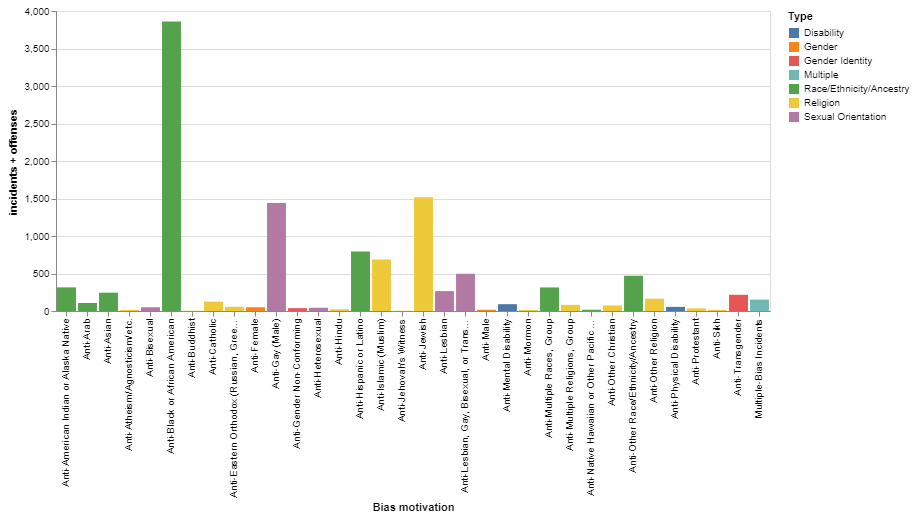

In [5]:
off_by_bias = off_by_bias_motivation.iloc[1:35,::]

off_by_bias['incidents + offenses'] = off_by_bias['Incidents'] + off_by_bias['Offenses']


incidents = alt.Chart(off_by_bias).mark_bar().encode(
    alt.X('Bias motivation'),
    alt.Y('incidents + offenses'),
    color='Type',
)

incidents

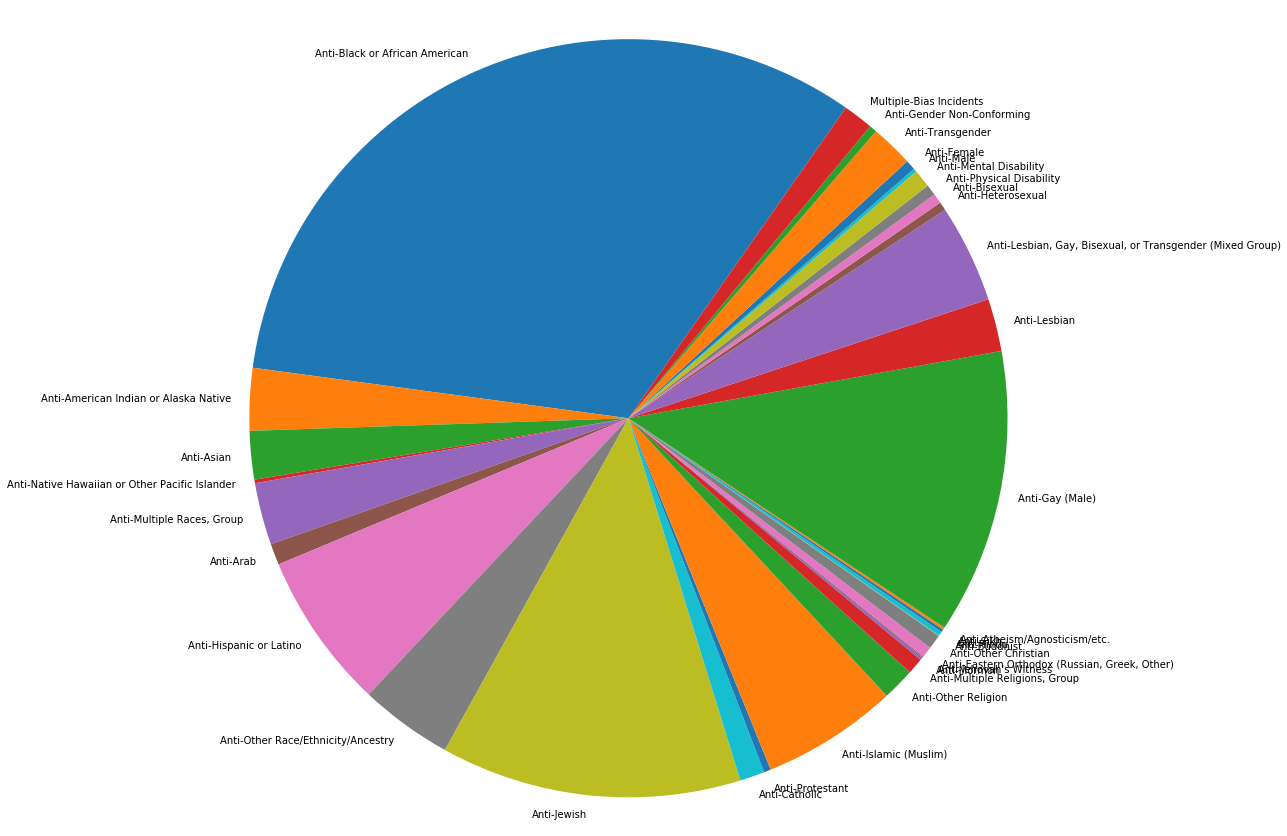

In [6]:
plt.figure(figsize=(15, 15))
plt.pie(x=off_by_bias['incidents + offenses'],startangle=55, labels = off_by_bias['Bias motivation'], labeldistance=1.05);
plt.axis('equal');
off_race_by_off_type[['Offense type', 'Hispanic or Latino',
       'Not Hispanic or Latino', 'Group of multiple ethnicities',
       'Unknown ethnicity', 'Unknown offender', 'Total']][0:15]

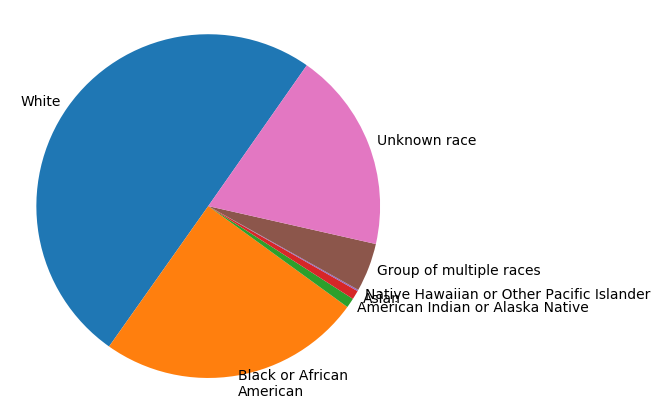

In [121]:
races = off_race_by_off_type[['Offense type', 'Hispanic or Latino',
       'Not Hispanic or Latino', 'Group of multiple ethnicities',
       'Unknown ethnicity', 'Unknown offender', 'Total']]

ethnicities = off_race_by_off_type[['Offense type', 'White', 'Black or African\nAmerican', 'American Indian or Alaska Native', 'Asian', 'Native Hawaiian or Other Pacific Islander', 'Group of multiple races', 'Unknown race', 'Unknown offender', 'Total']]


hi = ethnicities.drop(['Total'], axis = 1)
hi = ethnicities.T


ho = races.drop(['Total'], axis = 1)
ho = ho.T


plt.figure(figsize=(5, 5))
plt.pie(x=hi[17][1:8].astype(int),startangle=55, labels = hi.index[1:8], labeldistance=1.05);
plt.axis('equal');



## Hate crimes per 100k people by median household income

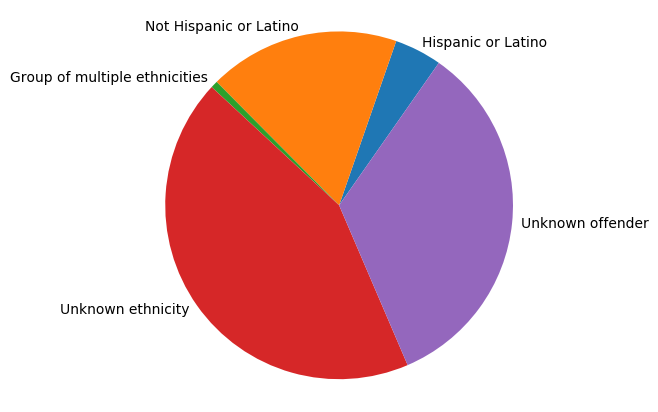

In [122]:
plt.figure(figsize=(5, 5))
plt.pie(x=ho[17][1:8].astype(int),startangle=55, labels = ho.index[1:8], labeldistance=1.05);
plt.axis('equal');

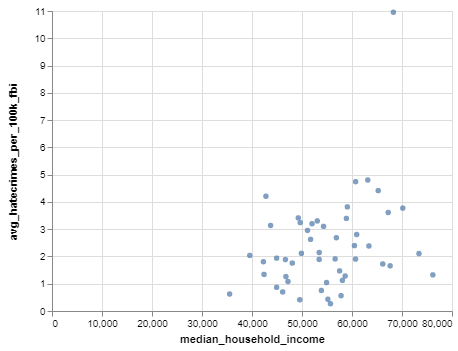

In [7]:
off_by_state = off_by_state.iloc[1::,::]
bystate = alt.Chart(data_538).mark_circle().encode(x = 'median_household_income', y = 'avg_hatecrimes_per_100k_fbi')

bystate
# may want to consider tying population in here

'3.4.2'

In [14]:
import plotly.plotly as py
import pandas as pd
import plotly

plotly.tools.set_credentials_file(username='caseyahlan', api_key='0WpK0XNGz71YCokMFYqB')

for col in data_538.columns:
    data_538[col] = data_538[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data_538['text'] = data_538['state'] + '<br>' +\
    'AVerage per 100k people '+data_538['avg_hatecrimes_per_100k_fbi']

data = [ dict(
        type='choropleth',
        colorscale =  scl,
        autocolorscale = False,
        locations = data_538['code'],
        z = data_538['avg_hatecrimes_per_100k_fbi'].astype(float),
        locationmode = 'USA-states',
        text = data_538['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Hate Crimes per 100k"
        )
    ) ]

layout = dict(
        title = 'Hate crimes per 100k people',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict( data=data, layout=layout )

py.iplot( fig, filename='d3-cloropleth-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~caseyahlan/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


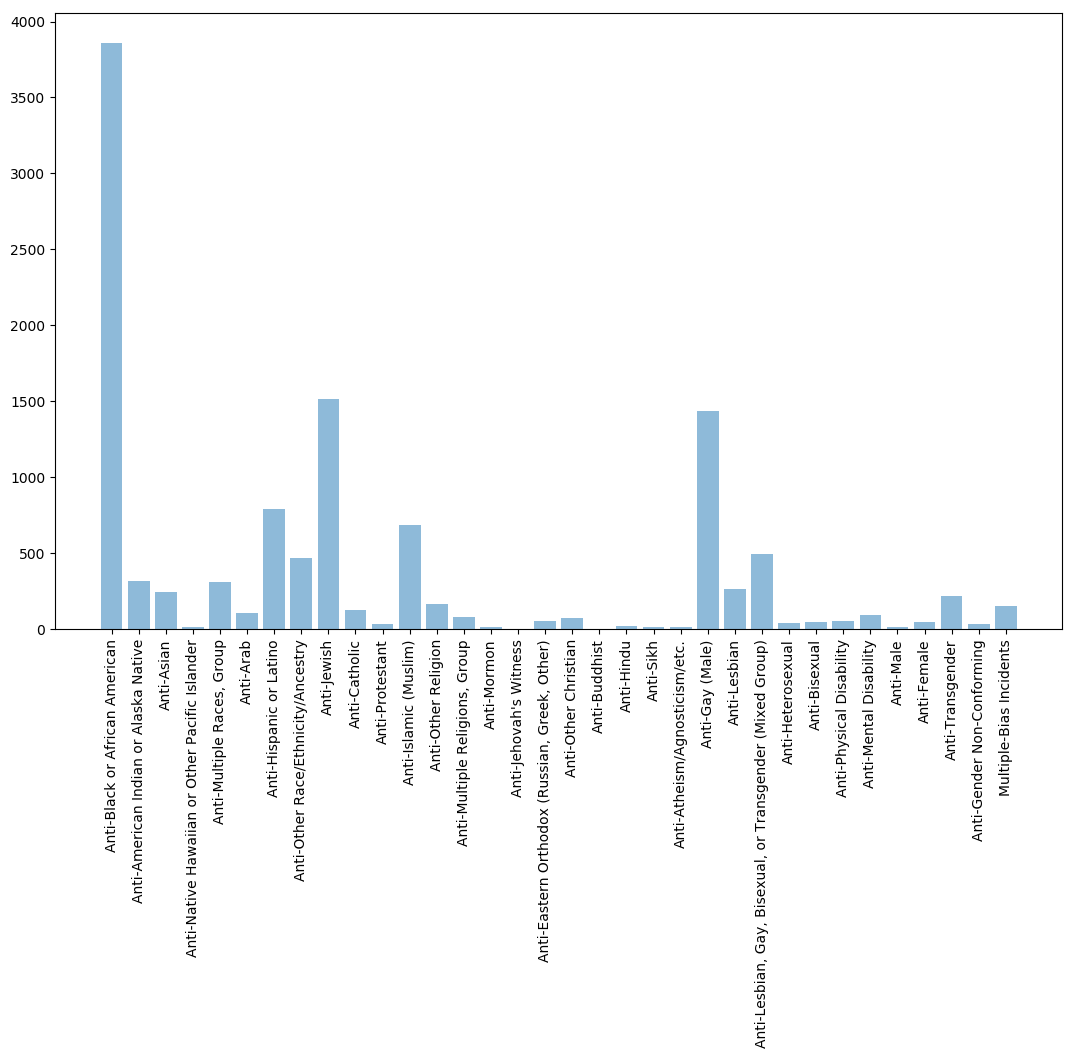

In [27]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = [10,8,6,4,2,1]
 
plt.figure(figsize=(13, 8))
plt.bar(off_by_bias['Bias motivation'], off_by_bias['incidents + offenses'], align='center', alpha=0.5)
plt.xticks(rotation=90)
#plt.xticks(y_pos, objects)
#plt.ylabel('Usage')
#plt.title('Programming language usage')
plt.show();


In [11]:
# Read in CSVs
#TODO: WHAT TO DO WITH NULL VALUES?
hate_crimes_by_socioeconomic = pd.read_csv("./data/hate_crimes.csv")


motivation_by_num_situation = pd.read_csv("./data/table_1_incidents_offenses_victims_and_known_offenders_by_bias_motivation_2016.csv").drop(["Unnamed: 5", "Unnamed: 6", "Unnamed: 7"], axis = 1)
offense_type_by_situation = pd.read_csv("./data/table_2_incidents_offenses_victims_and_known_offenders_by_offense_type_2016.csv").drop(["Unnamed: 5", "Unnamed: 6"], axis = 1)
offense_type_by_offender_race = pd.read_csv("./data/table_3_offenses_known_offenders_race_and_ethnicity_by_offense_type_2016.csv")
motivation_by_crime_type = pd.read_csv("./data/table_4_offenses_offense_type_by_bias_motivation_2016.csv")
motivation_by_offender_race = pd.read_csv("./data/table_5_offenses_known_offenders_race_and_ethnicity_by_bias_motivation_2016.csv").drop(["Unnamed: 14", "Unnamed: 15", " "], axis = 1)
location_by_motivation = pd.read_csv("./data/table_10_incidents_bias_motivation_by_location_2016.csv").drop(["Unnamed: 9", "Unnamed: 10", "Unnamed: 11", "Unnamed: 12"], axis = 1)
state_by_crime_type = pd.read_csv("./data/table_11_offenses_offense_type_by_participating_state_2016.csv")


KeyError: "labels ['Unnamed: 5'] not contained in axis"

# Statistical Modeling

Null Hypothesis
